# 최적화Optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp

sp.init_printing()

style_name = 'bmh' #bmh
mpl.style.use(style_name)
np.set_printoptions(precision=4, linewidth =150)

style = plt.style.library[style_name]
style_colors = [ c['color'] for c in style['axes.prop_cycle'] ]

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from IPython.core.display import display, HTML

init_notebook_mode(connected=True)

# https://github.com/plotly/plotly.py/issues/515
# The polling here is to ensure that plotly.js has already been loaded before
# setting display alignment in order to avoid a race condition.
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
from hidden_func import hidden_f

# 함수 임포트
try:
    print("try import optimize_ans")
    from optimize_ans import minimize, f_alpha, simple_grad_descent
    
except ImportError:
    print("import optimize")
    from optimize import minimize, f_alpha, simple_grad_descent

try import optimize_ans


## 최적화 학습의 목적 
    
- 어떤 함수는 우리의 목적을 잘 반영하는 함수여서 그 함수의 최소값을 찾으면 문제가 해결되는 경우가 많다.

- 따라서 주어진 함수를 최소화시키는 독립변수를 찾는 것에 관심이 많다.

- 즉, 어떤 $x$를 주어진 함수에 대입해야 함수값이 가장 작아질까?에 대한 고민을 해결하는 방법론을 학습하는 것이 목적이다.


## 학습 개요 

- 최적화 기법 중 경사 하강법에 대해 이해한다.
    
- 경사하강법 중에 최속강하법과 공액경사법에 대한 이해와 코드를 작성한다.

- scipy에서 제공하는 최적화 코드와 실습 코드의 결과를 비교한다.

- 주요 참고 문헌 및 예제 : Intoruduction to Optimum Design 2nd ed., Jasbir S. Arora, Elsevier





## 테스트 함수 로드

- 작성한 코드를 테스트할 미리 정의된 다음 3가지 함수를 로딩한다.

$$
\begin{aligned}
f_1(x,y) &= x^2 + y^2 \\[10pt]
f_2(x,y) &= \frac{1}{20} \left\{ x \cos(-0.7) - y \sin(-0.7) \right\}^2 + \frac{1}{2} \left\{ x \sin(-0.7) + y \cos(-0.7) \right\}^2 \\[10pt]
f_3(x,y) &= 50 \left(y-x^2\right)^2 + (2-x)^2
\end{aligned}
$$


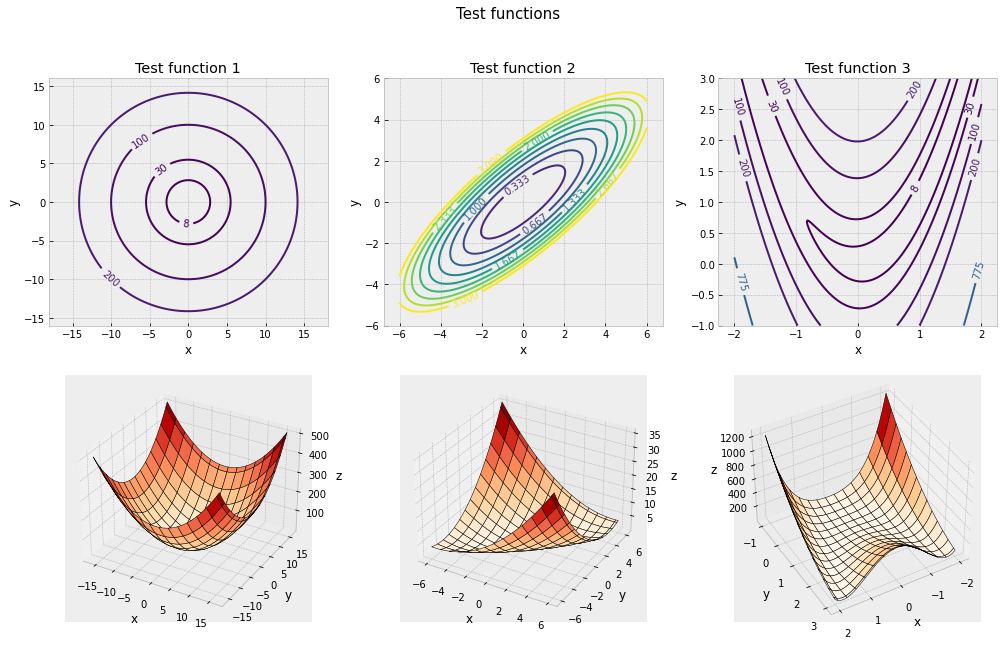

In [3]:
# 테스트에 쓸 함수를 따로 정의한 노트북 파일을 로드한다.
%run ./testfuncs.ipynb

- 세가지 함수는 모두 2변수 실함수이고 오른쪽으로 갈 수록 최적화 알고리즘을 적용하기 어려워지는 함수가 된다.

- 수업을 통해 최적화 알고리즘을 작성하고 각 함수에 적용하여 결과를 비교 해본다.

## 목적함수

- 주어진 함수의 값을 제일 작게 하는 독립변수를 구하기 위한 방법

- 함수의 최솟값은 왜 찾는가? $\to$ 최소값을 찾으면 좋은 결과가 나오도록 비용에 해당하는 함수를 적절히 구성한다. 


- 이런 함수를 목적함수<sup>objective</sup>, 비용함수<sup>cost</sup>, 손실함수<sup>loss</sup>라 한다.
    - 목적함수 : 우리의 목적을 달성하기 위한 함수
    - 비용함수 : 비용이 최소가 되면 좋다! 예) 자동차 개발에 있어서 생산 비용을 최소화하면서 연비를 최대화 할 수 있는 생산 방법
    - 손실함수 : 손실이 최소가 되면 좋다! 예) 이미지 압축 알고리즘에 있어서 원본 이미지의 손실이 최소화 되도록 하는 알고리즘

### 간단한 목적함수에 대한 필요조건

$$
y = x^2 -20x +100
$$

- 위 함수에서 $y$의 최소값은 0, $y$가 최소값이 되도록 하는 $x$는 10

- 어떻게 알수 있나?

$$
y = (x- 10)^2 \quad \text{or} \quad \frac{dy}{dx} = 2x-20 \overset{\underset{\mathrm{set}}{}}{=} 0
$$

- $x=10$으로 설정하면 $y$를 최소화할 수 있다.

- 함수의 최솟값 : 미분해서 0으로! 왜? 미분은 기울기, 기울기가 0이면 아래 또는 위로 볼록

In [4]:
x = sp.symbols('x')
sp.solveset(sp.diff(x**2 - 20*x + 100, x), x)

- 울퉁 불퉁한 함수면 미분해서 0인 지점이 여러개 있을 수 있다. $\to$ 다 구해서 비교하면 된다.

$$
y = x^3 -5x \quad x \in [-2,2]
$$

In [5]:
x = sp.symbols('x')
sp.solveset( sp.diff(x**3 - 5*x, x),  x )

- 아래는 `sympy`로 구한 해를 그래프로 표시한 것이다.

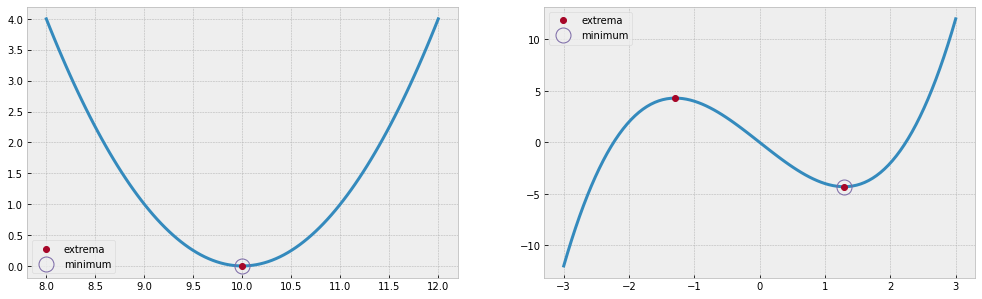

In [6]:
fig = plt.figure()
fig.set_size_inches((17,5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

x = sp.symbols('x')

x1 = np.linspace(8, 12, 100)
y1 = x1**2 - 20*x1 + 100
s1 = np.array(list(sp.solveset(sp.Eq(sp.diff(x**2 - 20*x + 100, x), 0), x)))
ax1.plot(x1, y1, lw=3)
ax1.plot(s1, s1**2 - 20*s1 + 100, 'o', label="extrema")
ax1.plot(s1, s1**2 - 20*s1 + 100, 'o',  fillstyle='none', markersize=15, label='minimum')
ax1.legend()

x2 = np.linspace(-3, 3, 100)
y2 = x2**3 - 5*x2
s2 = np.array(list(sp.solveset( sp.diff(x**3 - 5*x, x),  x )))
ax2.plot(x2, y2, lw=3)
ax2.plot(s2, s2**3 - 5*s2, 'o', label="extrema")
j = np.argmin(s2**3 - 5*s2)
ax2.plot(s2[j], (s2**3 - 5*s2)[j], 'o',  fillstyle='none', markersize=15, label='minimum')
ax2.legend()

plt.show()

### 2변수 이상의 목적함수를 위한 필요조건 

#### 테일러 급수<sup>Taylor series</sup>

- 미분가능한 함수를 어느 점 근처에서 다항식으로 근사하는 방법

- 스코틀랜드의 수학자 그레고리<sup>James Gregory</sup>가 시초

- 1715년 이후, 영국의 수학자 테일러<sup>Brook Taylor</sup>에 의해 널리 알려짐



<img src="imgs/BTaylor.jpg" width="200"/>
<h5 align="center">테일러Brook Taylor (1685-1731), Public Domain, https://en.wikisource.org</h5>
<br/>


$$
f(x) = f(x^*) + \frac{d f(x^*)}{dx} (x - x^*) + \frac{1}{2} \frac{d^2 f(x^*)}{dx^2}(x - x^*)^2 + R
$$

- 위 식의 의미는 어떤 점 $x^*$이 근처에서 함수 $f(x)$의 값은 위 식처럼 계산될 수 있다는 것 

- 약간 다르게 표현 하기 위해 $x-x^* = d$로 두고

$$
f(x^* + d) = f(x^*) + \frac{d f(x^*)}{dx} d + \frac{1}{2} \frac{d^2 f(x^*)}{dx^2}d^2 + R
$$

- 어떤 점 $x^*$에서 $d$만큼 떨어진 곳의 함수값은 $f(x^*)$를 중심으로 위 식처럼 계산될 수 있다.

- $e^x$라는 지수 함수를 $x=3$근방에서 다항식으로 표현하는 실험을 해보자



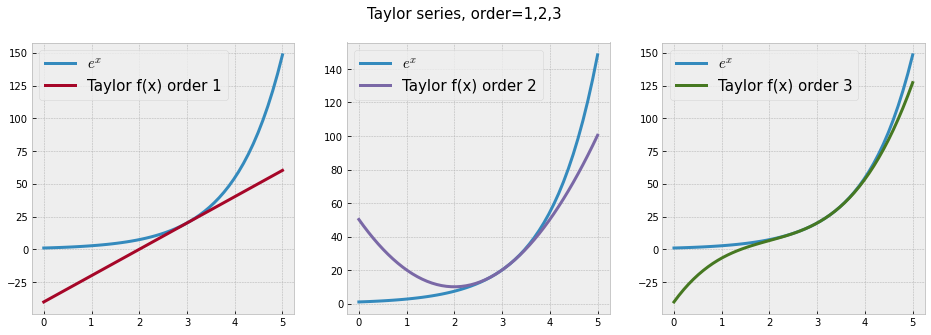

In [7]:
import math

def  taylor_e(x, a, n) :
    # x* = a 에서 전개
    # f(x) = e^{a} + e^{a}*(x-a) + e^{a}/2*(x-a)^2 + R
    fx =  np.exp(a)
    
    # 테일러 시리즈 전개, 각 항의 상수는 일반적으로 1/1!, 1/2!, 1/3!, ..., 1/N!
    for i in range(1, n+1) : 
        fx += np.exp(a)/math.factorial(i)*(x-a)**i
    
    #return np.exp(a) + np.exp(a)*(x-a) + np.exp(a)/2 * (x-a)**2
    return fx
    
x = np.linspace(0, 5)
y = np.exp(x)

fig, ax = plt.subplots(1,3)
fig.set_size_inches((16,5))

fx1 = taylor_e(x, 3, 1)
fx2 = taylor_e(x, 3, 2)
fx3 = taylor_e(x, 3, 3)

ax[0].plot(x, y , lw=3, label="$e^x$")
ax[0].plot(x, fx1, lw=3, label="Taylor f(x) order 1", color=style_colors[1])
ax[0].legend(fontsize=15)

ax[1].plot(x, y , lw=3, label="$e^x$")
ax[1].plot(x, fx2, lw=3, label="Taylor f(x) order 2", color=style_colors[2])
ax[1].legend(fontsize=15)

ax[2].plot(x, y , lw=3, label="$e^x$")
ax[2].plot(x, fx3, lw=3, label="Taylor f(x) order 3", color=style_colors[3])
ax[2].legend(fontsize=15);

plt.suptitle("Taylor series, order=1,2,3", fontsize=15)
plt.show()

- 1차 근사

$$
f(x) = e^3 + e^3(x-3) \approx 20 + 20(x-3) = 20x - 40
$$

- 2차 근사

$$
f(x) = e^3 + e^3(x-3) + \frac{1}{2} e^3 (x-3)^2 \approx 10x^2 -40x +50
$$

- 3차 근사

$$
f(x) = e^3 + e^3(x-3) + \frac{1}{2} e^3 (x-3)^2 + \frac{1}{6} e^3 (x-3)^3 \approx \frac{20}{6} x^3 -20x^2 + 50x -40
$$

- $x=3$ 근처에서 차수를 높여 테일러 시리즈를 전개할 수록 원함수에 가까운 모습이 되는 것을 확인

#### 2변수 이상 테일러 급수

- 2차 항을 각 변수별로 모두 만들어 줌

$$
\begin{aligned}
& f(x_1, x_2) \\[5pt]
= \, &  f(x_1^*, x_2^*) + \frac{\partial f}{\partial x_1}(x_1 - x_1^*) + \frac{\partial f}{\partial x_2}(x_2 - x_2^*) \\[5pt]
&+ \frac{1}{2} \left[ \frac{\partial^2 f}{\partial x_1^2}(x_1 - x_1^*)^2 + 2 \frac{\partial^2 f}{\partial x_1 \partial x_2} (x_1 - x_1^*)(x_2 - x_2^*) + \frac{\partial^2 f}{\partial x_2^2}(x_2 - x_2^*)^2 \right] \\[5pt]
&+ R
\end{aligned}
$$

- 시그마 기호로 쓰면

$$
\begin{aligned}
f(x_1, x_2) &=  f(x_1^*, x_2^*) + \sum_{i=1}^{2} \color{RoyalBlue}{\frac{\partial f}{\partial x_i}}(x_i - x_i^*)  \\[5pt]
&+ \frac{1}{2}  \sum_{i=1}^{2} \sum_{j=1}^{2}  \color{OrangeRed}{\frac{\partial^2 f}{\partial x_i \partial x_j}} (x_i - x_i^*)(x_j - x_j^*) +  R
\end{aligned}
$$

- 색깔로 표시된 부분은 경사도벡터와 헤시안 행렬의 성분임을 이용하여 더 간략히 쓰면

$$
f(\mathbf{x}) = f(\mathbf{x}^*) + \nabla f^{\text{T}}(\mathbf{x} - \mathbf{x}^*) + \frac{1}{2}(\mathbf{x}-\mathbf{x}^*)^{\text{T}} \mathbf{H}(\mathbf{x}-\mathbf{x}^*) + R
$$

- 1 변수와 마찬가지로 $\mathbf{x} - \mathbf{x}^* = \mathbf{d}$ 로 두면

$$
f(\mathbf{x}^* + \mathbf{d}) = f(\mathbf{x}^*) +  \nabla f^{\text{T}} \mathbf{d} + \frac{1}{2} \mathbf{d}^{\text{T}} \mathbf{H} \mathbf{d} + R
$$

- $f(\mathbf{x}^*)$를 이항하면 좌변은 $\Delta f = f(\mathbf{x}^* + \mathbf{d})-f(\mathbf{x}^*)$ 가 되고 이는 $\mathbf{x}^*$에서 $\mathbf{x}$로 이동했을 때 함수값의 변화량이 된다.

$$
\Delta f = \nabla f^{\text{T}} \mathbf{d} + \frac{1}{2} \mathbf{d}^{\text{T}} \mathbf{H} \mathbf{d} + R
$$



####  필요조건의 유도

- 함수편: 극값과 미분계수에서 미분계수가 0이 되는 지점이 극대 또는 극소라는 것을 알아보았다.

- 이러한 사실을 보이기 위해 좌우 극한을 부등식으로 비교하는 방법을 사용했었다.

- 다변수 함수에서도 한번 미분한 미분계수, 즉 경사도 벡터가 0인 지점이 국소 최소 또는 국소 최대가 된다는 사실은 동일하다.

- 다만 1변수 함수에서 처럼 좌우 극한의 조건으로 이 사실을 보일 수 가 없다. 다변수 함수가 되어 극한값으로 접근하는 방향이 무한대가 되기 때문이다.

- 때문에 앞서 설명한 테일러 시리즈 전개를 이용하게 된다.

- 위 테일러 시리즈 전개를 통한 $\Delta f$ 표현에서 $\mathbf{x}^*$가 국소적 최소라면  $\Delta f > 0$이어야만 한다.

- 왜냐하면 $\Delta f = f(\mathbf{x}^* + \mathbf{d})-f(\mathbf{x}^*)$인데 $\mathbf{x}^*$가 국소적 최소라면 항상 $f(\mathbf{x}^* + \mathbf{d})>f(\mathbf{x}^*)$이기 때문이다.

$$
\Delta f = \nabla f^{\text{T}} \mathbf{d} + \frac{1}{2} \mathbf{d}^{\text{T}} \mathbf{H} \mathbf{d} + R > 0
$$

- 즉 위 식이 어떠한 임의의 벡터 $\mathbf{d}$에 대해서도 성립해야 한다.

- 그러기 위해서 가장 지배적인 항인 첫번째 항 $\nabla f^{\text{T}} \mathbf{d}$이 $\mathbf{d}$의 선택 여부와 상관없이 항상 음수가 아니어야 한다.

- 그것을 가능케하는 경우는 $\nabla f = \mathbf{0}$밖에 없다.

- 따라서 다음과 같은 국소 최소를 위한 1계 필요조건을 얻게 된다.

$$
\nabla f = \mathbf{0}
$$



## 경사 하강법Gradient Descent Method



#### 식을 모른다고 가정하면...

<img src="imgs/gradient-descent.png" width="500">


- 위 그림에서 현재 위치를 $x^{(t)}$라 하고 함수가 생긴 전반적인 모습은 모른다고 가정
    - $x^{(t)}$ : $t$번째 반복에서 $x$
    - 차원이 높아지면 그림을 그릴 수 없고, 그릴 수 있다 하더라도 함수가 복잡하면 함수의 모습을 알 수 없다.


- $x^{(t)}$에서 선택할 수 있는 선택지는 $+$, $-$ 두 방향 뿐이다.

- 일단 양방향 다 아주 약간 움직여 보고 함수가 줄어드는 방향을 찾고 그 방향으로 어느정도 이동하여 $x^{(t+1)}$($t$번째 위치 다음 번이라는 의미)을 구할 수 있다. 

In [8]:
# hidden_func.py로 부터 임포트된 미지의 함수 f
# 우리는 함수 f의 모양을 전혀 모르고 오직 값만 찍어 볼 수 있다.
# 다음처럼 함수의 값은 계산가능하다.

print(hidden_f(1), hidden_f(11), hidden_f(13))

-6 14 42


- 이 함수에 대해서 위 설명한 방법대로 소위 '무식공격'을 해보자.

In [9]:
def brute_force(f, x0, d, max_iter) :
    """
    x0 : initial point
    d  : positive interval
    """
    for i in range(max_iter):
        c = f(x0)
        left, right = f(x0-d), f(x0+d)
    
        if left < c :
            x0 = x0-d
        elif right < c :
            x0 = x0+d
        
    return x0
    

In [10]:
brute_force(hidden_f, 0, 0.1, 200)

- 하지만 2변수 이상 함수가 되면 이동할 수 있는 방향이 무한대가 되므로 이런 방법을 사용할 수 없다.

> *함수값이 줄어드는 방향을 찾아주는 일반적인 방법이 필요하다.*

- 결과적으로 기울기 정보를 사용하게 되는데

- 최소화해야하는 함수의 식을 모르거나 미분하기 어렵다면 $\to$  수치미분 해야 한다.

- 수치미분을 통해 겨우 미분계수 $c$를 구했다고는 하지만 $x^{(t)}$에서 기울기가 $c$이라는 정보만으로 왼쪽으로 가야할지 오른쪽으로 가야할지 어떻게 알 수 있는가?

- 위 그림에서는 $c>0$인 경우 $-$로 이동한다.

<img src="imgs/gradient-descent2.png" width="500">

- $x^{(t)}$가 왼쪽에 있다면 $c<0$인 경우 $+$로 이동한다.

- 이렇게 미분 계수의 반대방향으로 이동하기 위해 다음처럼 업데이트 식을 구성한다.

$$
x^{(t+1)} =  x^{(t)} \color{OrangeRed}{-} \eta \frac{d  y \left(x^{(t)} \right)}{dx} 
$$

- 미분계수의 반대방향으로 움직인다는 방식이 작동하는데 대한 엄밀한 증명은 하지 않았지만 일반적으로 적용되는 방법

- 앞서 도함수를 이용해서 최적해를 구한 $y = x^2 -20x +100$함수에 대해서 상술한 반복법을 적용한 엑셀 예제가 `optimum.xlsx` 파일에 있다.

- 다변수 스칼라 함수에서 미분계수는 벡터가 되는데 이를 경사도 벡터<sup>gradient</sup>라 한다.

- 따라서 다변수 스칼라 함수인 경우에도 경사도 벡터의 반대방향으로 움직이면서 함수값을 줄여 나갈 수 있을 것이라 짐작할 수 있다.

- 아래 코드 블록은 1차원 경사하강법의 간단한 실험을 보여준다.

- 아래 코드 블록에서 도함수를 코딩하고

- optimize.py에 있는 simple_grad_descent함수를 완성하여 1차원 경사하강법을 완성해보자.

|c|=9.990000, f(x)=-5.991999, x=0.999000
|c|=7.992000, f(x)=-11.748477, x=1.798200
|c|=6.393600, f(x)=-15.433901, x=2.437560
|c|=5.114880, f(x)=-17.793596, x=2.949048
|c|=4.091904, f(x)=-19.304619, x=3.358238
|c|=3.273523, f(x)=-20.272328, x=3.685591
|c|=2.618819, f(x)=-20.892186, x=3.947473
|c|=2.095055, f(x)=-21.289314, x=4.156978
|c|=1.676044, f(x)=-21.543811, x=4.324582
|c|=1.340835, f(x)=-21.706957, x=4.458666
|c|=1.072668, f(x)=-21.811586, x=4.565933
|c|=0.858134, f(x)=-21.878719, x=4.651746
|c|=0.686508, f(x)=-21.921822, x=4.720397
|c|=0.549206, f(x)=-21.949518, x=4.775318
|c|=0.439365, f(x)=-21.967331, x=4.819254
|c|=0.351492, f(x)=-21.978802, x=4.854403
|c|=0.281194, f(x)=-21.986199, x=4.882523
|c|=0.224955, f(x)=-21.990978, x=4.905018
|c|=0.179964, f(x)=-21.994073, x=4.923014
|c|=0.143971, f(x)=-21.996083, x=4.937412
|c|=0.115177, f(x)=-21.997392, x=4.948929
|c|=0.092141, f(x)=-21.998248, x=4.958143
|c|=0.073713, f(x)=-21.998811, x=4.965515
|c|=0.058971, f(x)=-21.999183, x=4.

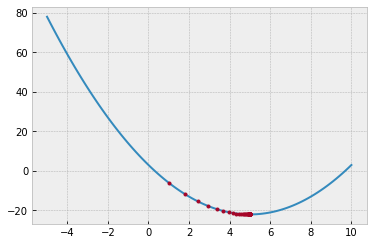

In [11]:
x = 0           # 탐색을 시작할 초기값
eta = 0.1       # 이동 거리
sols = []

def df(x):
    dx = 0.0
    
    ##################################
    # WRITE YOUR CODE HERE
    # df에 함수 hidden_f의 미분계수를 정의하세요.
    dx = (hidden_f(x+0.01) - hidden_f(x)) / 0.01
    
    return dx

simple_grad_descent(x, hidden_f, df, eta, sols)

xs = np.linspace(-5, 10, 100)
sols = np.asarray(sols)
plt.plot(xs, hidden_f(xs))
plt.plot(sols[:,0], sols[:,1], '.')
plt.show()

### 표기법

- $k$ 또는 $t$ : 알고리즘을 반복할때 반복 횟수

- $\mathbf{c}^{(k)}$ : $k$번째 반복에서 경사도벡터

- $\mathbf{d}^{(k)}$ : $k$번째 반복에서 강하방향

- $\alpha_k$, $\eta$  : $k$번째 반복에서 $\mathbf{d}^{(k)}$방향으로의 스탭사이즈 또는 고정된 러닝레이트

### 경사도 벡터를 사용하는 수치 알고리즘 일반개념

- 최적화 수치 알고리즘은 일반적으로 다음 단계를 따름
<div class="summary">
단계 1. 타당성있는 출발점 $\mathbf{x}^{(0)}$ 추정, $k=0$<br/>
단계 2. 탐색방향 $\mathbf{d}^{(k)}$를 계산<br/>
단계 3. 수렴 검토<br/>
단계 4. 양의 이동거리 $\alpha_k$ 계산(여러 다양한 알고리즘을 적용 가능)<br/>
단계 5. 새로운 설계 변수 계산 $\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}$, $k=k+1$ 단계 2로 가서 반복 <br/>
</div>    

    
- 따라서   $\alpha_k$와   $\mathbf{d}^{(k)}$ 계산이 중요한데 다음 순서로 알아본다.
    - 단계 2에서 경사도 벡터로 부터 결정되는 탐색방향 $\mathbf{d}^{(k)}$의 의미
    - 단계 4에서 양의 이동거리 $\alpha_k$의 의미

### 경사도 벡터Gradient

- $n$개의 변수 $x_1$, $x_2$, ... , $x_n$에 대한 함수 $f(\mathbf{x})$의 $\mathbf{x}^*$에서의 편미분

$$
c_i = \frac{\partial \, f(\mathbf{x}^*)}{\partial \, x_i}, \quad i=1, \dots, n
$$

- 이를 열벡터로 모으면 경사도 벡터

$$
\triangledown f(\mathbf{x}^*) = \begin{bmatrix}
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_1} \\[15pt]
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_2} \\[15pt]
\vdots \\[10pt]
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_n}
\end{bmatrix} = \begin{bmatrix}
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_1} &
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_2} &
\cdots &
\dfrac{\partial \, f(\mathbf{x}^*)}{\partial \, x_n}
\end{bmatrix}^{\text{T}}
$$

- $\nabla$ : 각 성분으로의 미분 연산을 의미하며 '나블라'<sup>nabla</sup>라고 읽음



#### 예제 

- 다음 함수에서 점(2,2)에서의 경사도벡터를 계산

$$
f(\mathbf{x}) = x_1^3 + x_2^3 + 2x_1^2 + 3x_2^2 - x_1 x_2 + 2x_1 + 4x_2
$$

- 1계 편도함수

$$
\begin{aligned}
\frac{\partial f}{\partial x_1} = 3 x_1^2 + 4 x_1 - x_2 + 2 \\[15pt]
\frac{\partial f}{\partial x_2} = 3 x_2^2 + 6 x_2 - x_1 + 4 
\end{aligned}
$$

- $x_1 = 2$, $x_2 = 2$에서의 경사도 벡터

$$
\nabla f(2,2) = \begin{bmatrix} 20 \\[10pt] 27 \end{bmatrix}
$$




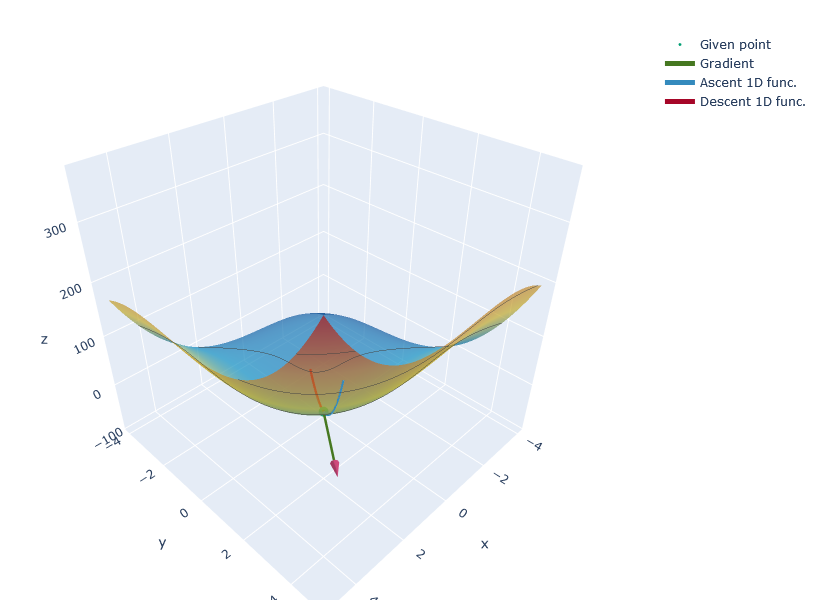

In [12]:
# https://plot.ly/python/
# https://plot.ly/python/offline/

def ex_func(x) :
    return  x[0]**3 + x[1]**3 + 2*x[0]**2 + 3*x[1]**2 - x[0]*x[1] + 2*x[0] + 4*x[1]

x = y = np.arange(-4.0, 5.0, 0.05)
X, Y = np.meshgrid(x, y)
Z = ex_func(np.array([X, Y]))

X0 = np.array([2,2])
z0 = ex_func(X0)
c = np.array([20, 27])
c = c / np.linalg.norm(c)

# 주어진 그래디언트로 만든 1차원 곡선
alphas = np.linspace(0, 3, 100)
univar_fun = []
for a in alphas :
    x_new = X0 + a * c
    univar_fun.append( [x_new[0], x_new[1], f_alpha(a, ex_func, np.array([2., 2.]), c )] )

fz1 = np.array(univar_fun)

alphas = np.linspace(-3, 0, 100)
univar_fun = []
for a in alphas :
    x_new = X0 + a * c
    univar_fun.append( [x_new[0], x_new[1], f_alpha(a, ex_func, np.array([2., 2.]), c )] )

fz2 = np.array(univar_fun)

# 주어진 곡면
surf = go.Surface(x=X, y=Y, z=Z, showscale=False, colorscale='Portland',
                  contours=dict(
                      x=dict(show=False, highlight=False),
                      y=dict(show=False, highlight=False),
                      z=dict(show=True,  highlight=True, highlightcolor='#A60628'),
                  ), opacity=0.7,
                 )

# point (2,2)
points = go.Scatter3d( x = [X0[0]], y = [X0[1]], z = [z0],
                       mode = 'markers',
                       marker = dict(size = 3, color = style_colors[7]),
                       name='Given point'
                     )

# 경사도 벡터
vector = go.Scatter3d( x = [X0[0], X0[0]+c[0]*2], y = [X0[1], X0[1]+c[1]*2], z = [z0, z0],
                       marker = dict(size = 1, color = style_colors[3]),
                       line = dict(color = style_colors[3], width = 5),
                       name='Gradient'
                     )

cone = { 'x':[X0[0]+c[0]*2], 'y':[X0[1]+c[1]*2], 'z':[z0], 
         'u':[c[0]], 'v':[c[1]], 'w':[0], 
         'name': 'gradient', 'type':'cone', 
         'showscale':False,
         'sizemode': "absolute", 'anchor':'tail',}

# 경사도 벡터 방향으로 일차원 함수
traj1 = go.Scatter3d( x = fz1[:,0], y = fz1[:,1], z = fz1[:,2],
                     mode = 'lines',
                     line = dict(color=style_colors[0], width=5),
                     name='Ascent 1D func.'
                     )

traj2 = go.Scatter3d( x = fz2[:,0], y = fz2[:,1], z = fz2[:,2],
                     mode = 'lines',
                     line = dict(color=style_colors[1], width=5),
                     name='Descent 1D func.'
                     )

data = [surf, points, vector, traj1, traj2, cone]

layout = go.Layout(
    autosize=False, 
    width=600, height=600,
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

- 위 그림은 $(x=2,y=2)$에서 경사도 벡터와 경사도 벡터 방향으로 증가하는 1차원 함수와 감소하는 1차원 함수를 나타낸 것이다.

- 초록색 화살표가 경사도 방향을 나태낸다. 

- 파란색 곡선은 경사도 방향을 따라 증가하는 1차원 함수, 빨간색 곡선은 경사도 방향을 따라 감소하는 1차원 함수를 나타낸다.

#### 경사도벡터의 중요 성질 

- 다음 두 경사도벡터의 성질은 경사하강법의 근간으로 매우 중요

    - #### 1. 함수표면의 접면에 수직

    - #### 2. 경사도벡터의 방향은 함수의 최대증가방향

<img src="imgs/grad-prop2.png" width="650" />

- 위 그림에서 함수값 0.4에서 0.8로 가려고 할때 가장 빠른 경로는 녹색 경로이며 이는 주어진 위치에서의 경사도 벡터가 된다.

- 그림으로 부터 녹색 벡터는 함수의 등고선의 접선에 대해 수직임을 알 수 있다.

- 약간의 편미분 지식과 방향 미분에 대한 기초적인 지식으로 증명가능<sup>[부록]</sup>

- 정리하면 경사도 벡터가 가르키는 방향이 함수의 최대 증가 방향이 되므로 경사도 벡터의 반대방향으로 이동하면 함수값을 가장 빠르게 감소시킬 수 있다.

- 이렇게 함수를 감소시키는 방향을 강하방향<sup>descent direction</sup>이라하고 강하방향에 기반한 방법을 강하법<sup>descent method</sup> 이라 한다.

- 강하 방향은 다음과 같은 강하조건<sup>descent condition</sup>을 만족

$$
\mathbf{c}^{(k)} \cdot \mathbf{d}^{(k)} = \lvert \mathbf{c}^{(k)} \rvert \lvert \mathbf{d}^{(k)} \rvert \cos \gamma  < 0 
$$

- 위 부등식의 의미 : **$\mathbf{x}^{(k)}$를 $\mathbf{x}^{(k+1)}$로 개선시키기 위한 탐색방향 $ \mathbf{d}^{(k)}$는 $k$번째 위치에서 계산된 경사도벡터 $\mathbf{c}^{(k)}$와 90&deg;에서 270&deg; 사이에 있어야 한다.**

<img src="imgs/descent-direction.png" width="650">


### 이동거리 <sup> step size</sup>

- 이동 방향이 경사도벡터에 의해 결졍되었으면 그 방향으로 이동 거리를 결정해야 한다.

- 올바른 방향 $\mathbf{d}^{(k)}$를 알 때 설계변수의 업데이트는 아래와 같이

$$
f \left(\mathbf{x}^{(k+1)} \right) = f\left(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)}\right)
$$

- $\alpha$만의 함수로 목적함수가 업데이트 된다.

$$
f\left(\mathbf{x}^{(k+1)}\right) = f\left(\mathbf{x}^{(k)} + \alpha \mathbf{d}^{(k)}\right) = \bar{f}(\alpha)
$$

- 즉, 현재 위치 $\mathbf{x}^{(k)}$에서 $\mathbf{d}^{(k)}$방향으로 양수 $\alpha$ 만큼 나아가면서 목적함수 $f$를 줄여나간다.

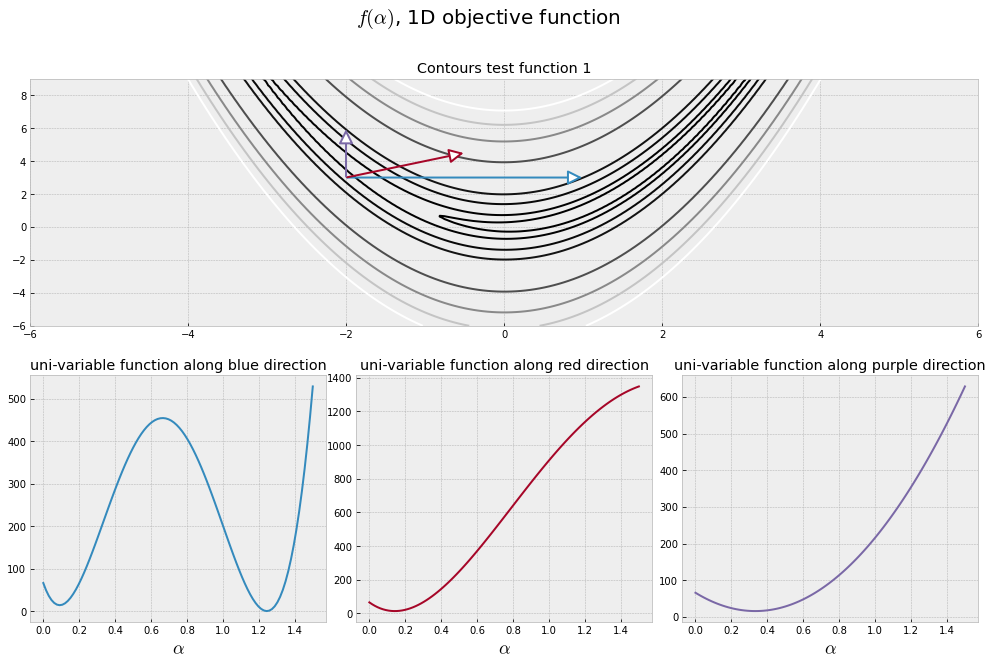

In [13]:
from matplotlib.patches import ConnectionPatch

fig = plt.figure(figsize=(17,10))

grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.2)

ax1 = plt.subplot(grid[0,0:])
axs = [ plt.subplot(grid[1,0]), plt.subplot(grid[1,1]), plt.subplot(grid[1,2])]

dirs = np.array([[3, 0], [1.5, 1.5], [0, 3]])
colors = ['blue', 'red', 'purple']

for i, d in enumerate(dirs) :
    con = ConnectionPatch(xyA=(-2, 3), xyB=(-2+d[0], 3+d[1]), coordsA="data", coordsB="data", color=style_colors[i], lw=2,
                         arrowstyle="-|>", shrinkA=1, shrinkB=1,
                          mutation_scale=30, fc="w", zorder=2)
    ax1.add_artist(con)
    
ax1.set_title("Contours test function 1")
    
x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 9, 200)
X,Y = np.meshgrid(x,y)
Z = f_3([X, Y])

ax1.contour(X, Y, Z, levels=np.concatenate((levels1, levels2, levels3)), cmap='gray')

alphas = np.linspace(0, 1.5, 100)

for i in range(3):
    univar_fun = []
    for a in alphas :
        univar_fun.append( f_alpha(a, f_3, np.array([-2.,  3.]), np.array(dirs[i]) ) )
    axs[i].plot(alphas, np.asarray(univar_fun), color=style_colors[i])
    axs[i].set_xlabel(r'$\alpha$', fontsize=18)
    axs[i].set_title('uni-variable function along {} direction'.format(colors[i]))
    
plt.suptitle(r"$f(\alpha)$, 1D objective function", fontsize=20)
plt.show()

#### 선탐색<sup>line search</sup>

- 위 코드는 테스트 함수3번에 대해 (-2,3)에서 각각 세 방향으로 진행할 때 1차원 함수를 나타낸 것이다. 

- 이렇게 얻어진 1변수 함수를 최소화하기 위해 다시 경사하강법을 쓸 수 도 있으나 이는 많은 계산 비용<sup>computational cost</sup>를 필요로 하므로 특별히 선탐색<sup>line search</sup>라는 방법으로 다양한 알고리즘이 존재


- 다양한 선탐색 알고리즘
    - 등간격 탐색<sup>equal step search</sup>
    - 황금분할 탐색<sup>golden section search</sup>
    - 다항식 보간법<sup>polynomial interpolation</sup> 등등
    
    
- 실습에서는 황금분할 탐색을 사용하나 일반적인 머신러닝 알고리즘에서는 선탐색을 하지 않으므로 더 깊이 학습할 필요는 없고 필요하다면 자세한 내용은 [arora, wiki:gss]을 참고하면 된다.

- 선탐색의 결과로 얻어지는 결과는 강하방향으로 얼마나 전진할지를 결정하는 스텝사이즈가 된다.

#### 선탐색하지 않는 경우

- 선탐색에 대한 비용이 너무 크고 최적화 알고리즘에 따라 확률적으로 목적함수가 매 반복에서 조금씩 바뀌는 경우가 있다.

- 대부분의 머신러닝 과정이 이에 해당하며 이 경우 탐색방향만 결정하고 선탐색은 하지 않는다.

- 결정된 탐색방향으로 얼마만큼 나갈지 스텝사이즈를 고정 상수 $\alpha$로 둠

- 이런 경우 $\alpha$를 학습률<sup>learning rate</sup>라 함 

- $\eta$로 표기하는 경우도 많음


- 경사도 벡터에 기반하지 않는 방법인 경우 선탐색 하지 않는데 예를 들어 Nelder-Mead method<sup>[nocedal]</sup>같은 방법이 있다.


### 변수 업데이트

<img src="imgs/variable-update.png" width="400"/>

- 위 그림처럼 $\mathbf{x}^{(k)}$에서 강하방향 $\mathbf{d}^{(k)}$와 스텝사이즈 $\alpha$가 결정되었으면 

- 새로운 $\mathbf{x}^{(k+1)}$을 계산하기 위해 벡터 $\mathbf{x}^{(k)}$와 벡터 $\alpha\mathbf{d}^{(k)}$를 더해준다.

### 비제약 최소화 알고리즘

- warmup_optim.ipynb에서 본 예제의 경우 설계변수에 이런저런 제약조건이 걸려 있는 경우에 해당

- 설계변수에 대한 제약조건이 없는 경우를 비제약 최소화<sup>unconstrained optimization</sup>이라 하고 수업에서는 대표적인 2가지 알고리즘인 최속강하법과 공액경사도법을 알아보도록 한다.

#### 최속강하법<sup>steepest descent method</sup>

- 최속강하법 알고리즘<sup>[arora]</sup>
<div class="summary">
    
    **Step 1**. Estimate a starting design as $\mathbf{x}^{(0)}$. Set the iteration counter $k=0$. Select the convergence parameter $\epsilon$. 
    $$
    $$

    **Step 2**.  Calculate the gradient of $f(\mathbf{x})$ at the current point $\mathbf{x}^{(k)}$ as $\mathbf{c}^{(k)} = \triangledown f\left(\mathbf{x}^{(k)}\right )$.
    $$
    $$
                   
    **Step 3**.  Calculate the length of $\mathbf{c}^{(k)} $ as $\lVert \mathbf{c}^{(k)} \rVert$. If $\lVert \mathbf{c}^{(k)} \rVert < \epsilon$ , then stop the iterative process because $\mathbf{x}^* = \mathbf{x}^{(k)}$ is a local minimum point. Otherwise, continue.
    $$
    $$
        
    **Step 4**.   Let the search direction at the current point $\mathbf{x}^{(k)}$ be $\mathbf{d}^{(k)} = - \mathbf{c}^{(k)}$. 
    $$
    $$
                
    **Step 5**. Calculate a step size $\alpha_k$ that minimizes $f(\alpha)=f\left(\mathbf{x}^{(k)}+\alpha \mathbf{d}^{(k)}\right)$ in the direction $\mathbf{d}^{(k)}$. Any one-dimensional search algorithm may be used to determine $\alpha_k$.
    $$
    $$
    
    **Step 6**. Change the design as follows: set $k=k+1$ and go to Step 2.
    $$
    \mathbf{x}^{(k+1)} =  \mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}
    $$
</div>



#### 공액경사도법<sup>conjugate gradient method</sup>

- 공액경사도법 알고리즘<sup>[arora]</sup>
<div class="summary">
    
    **Step 1**. Estimate a starting design as $\mathbf{x}^{(0)}$. Set the iteration counter $k=0$. Select the convergence parameter $\epsilon$. Calculate
    $$
    \mathbf{d}^{(0)} = - \mathbf{c}^{(0)} = - \triangledown f \left( \mathbf{x}^{(0)} \right)
    $$Calculate $\lVert \mathbf{c}^{(k)} \rVert$. If  $\lVert \mathbf{c}^{(k)}  \rVert < \epsilon$, then stop; otherwise go to Step 5.    
    $$
    $$
    
    **Step 2**. Compute the gradient of the cost function as 
    $$
    \mathbf{c}^{(k)}=\triangledown f\left(\mathbf{x}^{(k)}\right)
    $$
    $$
    $$
    
    **Step 3**. Calculate $\lVert \mathbf{c}^{(k)} \rVert$. If  $\lVert \mathbf{c}^{(k)}  \rVert < \epsilon$, then stop; otherwise continue.
    $$
    $$
        
    **Step 4**.  Calculate the new conjugate direction as (fletcher and reeves (1964))
    $$
    \begin{aligned}
    \mathbf{d}^{(k)} &= - \mathbf{c}^{(k)} + \beta_{k} \mathbf{d}^{(k-1)} \\[5pt]
    \beta_k &= \left( \frac{\lVert \mathbf{c}^{(k)} \rVert}{\lVert \mathbf{c}^{(k-1)} \rVert} \right)^2
    \end{aligned}
    $$ 
<br/>    
    
    **Step 5**. Compute a step size $\alpha_k = \alpha$ to minimize $f(\alpha) = f\left(\mathbf{x}^{(k)}+\alpha\mathbf{d}^{(k)} \right)$.
    $$
    $$
    
    **Step 6**. Change the design as follows: set $k=k+1$ and go to Step 2.
    $$
    \mathbf{x}^{(k+1)} =  \mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}
    $$
</div>



- 아래 실습 코드 중 최속강하법과 공액경사법의 비교하는 코드를 성공적으로 수행하면 공액경사법에서 공액 경사 방향이 탐색방향에 어떤 영향을 주는지 확인할 수 있다.

- 아래와 같은 탐색 경로 그림을 얻게 된다.

<img src="imgs/sdm-vs-cgm.png">

## 코드 실습

- 이상 논의한 내용을 모두 python 코드로 구현한다.

- 우선 작성한 코드와 비교대상을 만들기 위해 `scipy`에서 제공하는 `optimize` 모듈의 `minimize` 함수를 사용하여 테스트 함수 3번에 대한 해를 구한다.

     fun: 1.9190750854306276e-11
     jac: array([3.9861e-07, 1.4391e-06])
 message: 'Optimization terminated successfully.'
    nfev: 282
     nit: 38
    njev: 94
  status: 0
 success: True
       x: array([2., 4.])
1.9190750854306276e-11


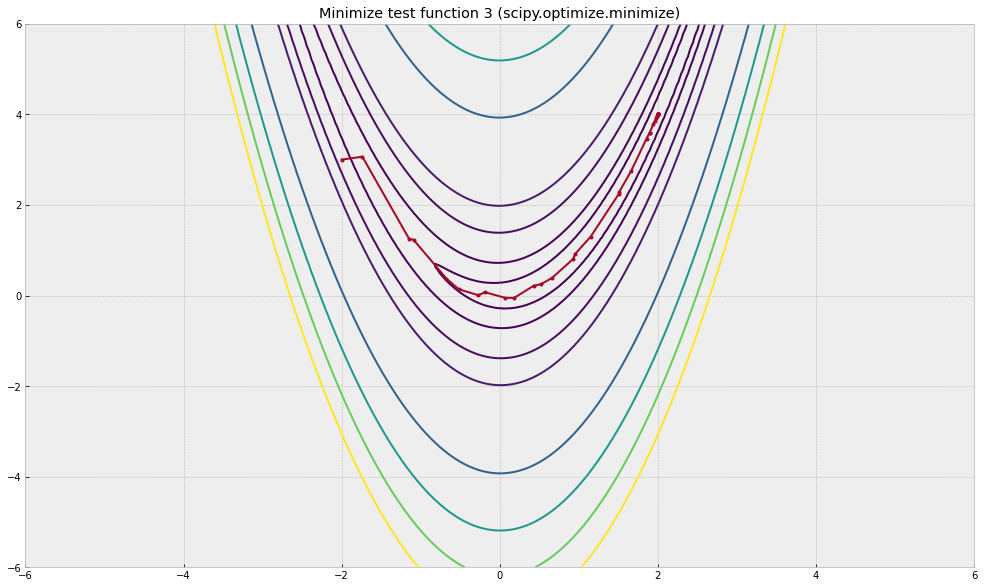

In [14]:
from scipy import optimize

# 반복 히스토리를 저장할 전역변수와 콜백함수
scipy_Xk = []
def record_hist(xk) :
    global scipy_Xk
    scipy_Xk.append(xk)

x0 =  np.array([-2.,3.])
# x0 =  np.array([0.,0.]) 

# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
# CG, BFGS, Nelder-Mead, SLSQP
result_xy = optimize.minimize(f_3, x0, method='CG', callback=record_hist)
print(result_xy)
print(f_3(result_xy['x']))

scipy_Xk = np.r_['0,2,1', x0, np.asarray(scipy_Xk)]

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
X,Y = np.meshgrid(x,y)

Z = f_3([X, Y])

plt.figure(figsize=(17,10))
plt.contour(X, Y, Z, levels=np.concatenate((levels1, levels2, levels3)))
plt.plot(scipy_Xk[:,0], scipy_Xk[:,1], '.-', color=style_colors[1])
plt.title('Minimize test function 3 (scipy.optimize.minimize)')
plt.show()


### optimize.minimize()함수 코딩

- 위 그림은 `scipy.optimize.minimize`의 해 탐색 과정을 출력한 것이고 위 결과와 동일하게 작동하는 라이브러리를 작성

- 코드 뼈대는 `optimize.py`에 미리 코딩되어 있고, `WRITE YOUR CODE HERE`부분을 완성하고 코드 블록을 실행하여 검증한다.

- `optimize.py`에 있는 함수 목록 

- #### <span class="code-body">def f_alpha(alpha, fun, x, s, args)</span>
    - 탐색 방향이 정해진 후 탐색방향으로 결정되는 1차원 탐색함수


-  #### <span class="code-body">def gss(fun, x, s, args, tol=1e-15, delta=1.0e-2)</span><sup>[arora],[wiki:gss]</sup>
    - 탐색 방행으로 목적함수의 가장 낮은 곳을 찾기 위해 앞서 정의된 <span class="code-body">f_alpha</span>를 최소화 시키는 함수
    - <span class="code-body">scipy.optimize.line_search</span>를 사용해도 됨
    
    
-  #### <span class="code-body">numer_grad(x, fun, args)</span>
    - 목적함수의 미분된 함수를 제공할 수 없을 대 목적함수를 수치미분하는 함수


-  #### <span class="code-body">minimize(fun, x0, args=(), method='CGFR', jac=None, ...)</span>
    - 목적함수를 최소화시키는 함수
    - 이 함수를 코딩해본다.

#### 사용법

- 완성된 `minimize` 함수의 사용법은 아래와 같다.

```python
x_star = minimize(f_3,                           # f_3 함수
                  x0,                            # x0에서부터 시작 
                  method="CGFR",                 # 공액경사법(플레처-리브스)을 사용
                  lineargs={'delta':1.0e-3},     # 선탐색에 필요한 파라미터
                  callback=record_hist2          # 히스토리를 record_hist2함수로 기록 
                 )

x_star = minimize(f_3,                           # f_3 함수를
                  x0,                            # x0에서부터 시작해서 
                  method="CGPR",                 # 공액경사법(폴락-리비에르)을 사용해서
                  jac=df_3,                      # 그래디언트는 df_3으로 계산하고
                  linesrch=optimize.line_search, # 선탐색은 scipy.optimize.line_search를 사용
                  lineargs={'c2':0.1},           # 선탐색에 필요한 파라미터
                  callback=record_hist2)         # 히스토리를 record_hist2함수로 기록 

x_star = minimize(f_3,                           # f_3 함수를
                  x0,                            # x0에서부터 시작해서 
                  method="CGPR",                 # 공액경사법(폴락-리비에르)을 사용해서
                  linesrch=None,                 # 선탐색 하지 않고
                  lineargs={'lr':0.0015},        # 무조건 0.0015만큼 전진
                  strict=False,                  # 목적함수값이 증가할 수도 있음
                  verbose_step=500,              # 반복 출력을 매 500회 마다
                  callback=record_hist2)         # 히스토리를 record_hist2함수로 기록 
```

[-2.  3.]
################################################################
# START OPTIMIZATION
################################################################
INIT POINT : [-2.  3.], dtype : float64
METHOD     : Conjugate gradient Polak and Ribiere
##############
# START ITER.
##############
Iter:    1, |c|:420.0761836, alpha:0.0006267, Cost: 14.0399610, d:[408. 100.], x:[-1.7443  3.0627]
Iter:   11, |c|:  9.7801538, alpha:0.0631429, Cost:  1.1808951, d:[ 9.7105 13.351 ], x:[0.9506 0.8637]
Iter:   21, |c|:  5.6507400, alpha:0.0007160, Cost:  0.0057334, d:[ 6.4433 45.8526], x:[1.9244 3.7036]
Stop criterion break
Iter:   28, |c|:  0.0000000, alpha:0.0010398, Cost:  0.0000000, d:[-4.3977e-06 -1.8349e-05], x:[2. 4.]


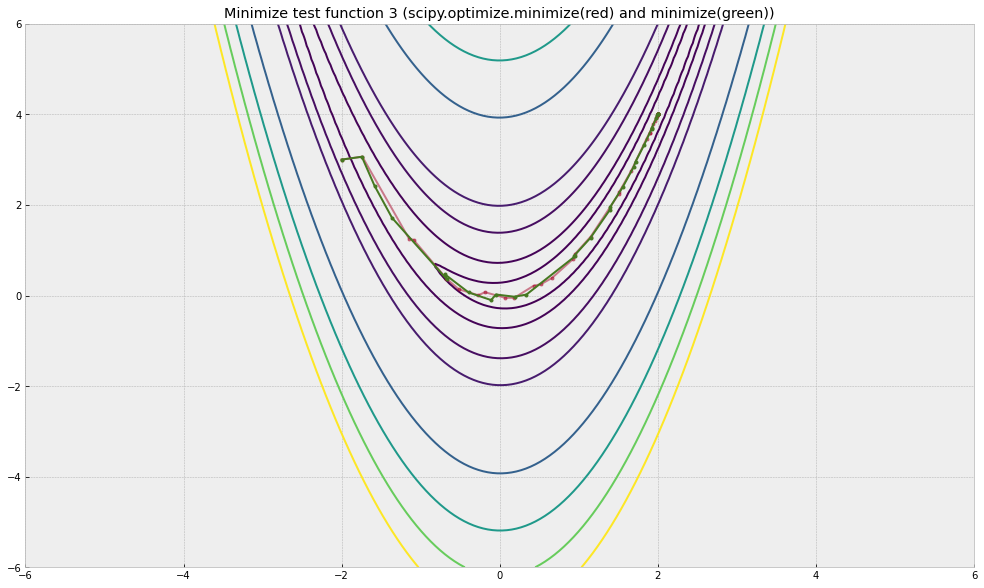

In [15]:
print(x0)

# 반복 히스토리를 저장할 전역변수와 콜백함수
my_Xk = []
def record_hist2(xk) :
    global my_Xk
    my_Xk.append(xk)

# by using golden section search
x_star = minimize(f_3, x0, method="CGPR", jac=df_3, 
                 lineargs={'delta':1.0e-3}, callback=record_hist2)

my_Xk = np.r_['0,2,1', x0, np.asarray(my_Xk)]

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)

X,Y = np.meshgrid(x,y)

Z = f_3([X, Y])

plt.figure(figsize=(17,10))
plt.contour(X, Y, Z, levels=np.concatenate((levels1, levels2, levels3)))
plt.plot(scipy_Xk[:,0], scipy_Xk[:,1], '.-', alpha=0.5, color=style_colors[1])
plt.plot(my_Xk[:,0], my_Xk[:,1], '.-', color=style_colors[3])
plt.title('Minimize test function 3 (scipy.optimize.minimize(red) and minimize(green))')
plt.show()

### 최속강하법과 공액경사도법의 탐색 경로 비교

- 완성된 라이브러리로 최속강하법과 공액경사도법의 탐색경로를 비교 해본다.


################################################################
# START OPTIMIZATION
################################################################
INIT POINT : [-1 -2], dtype : int32
METHOD     : Steepest Descent
##############
# START ITER.
##############
Iter:    1, |c|:  0.9089614, alpha:1.0481354, Cost:  0.1698327, d:[-0.4134  0.8095], x:[-1.4333 -1.1515]
Iter:   11, |c|:  0.0016133, alpha:1.0481354, Cost:  0.0000005, d:[-0.0007  0.0014], x:[-0.0025 -0.002 ]
Iter:   21, |c|:  0.0000029, alpha:1.0481354, Cost:  0.0000000, d:[-1.3022e-06  2.5500e-06], x:[-4.5149e-06 -3.6273e-06]
Stop criterion break
Iter:   26, |c|:  0.0000000, alpha:1.0481354, Cost:  0.0000000, d:[-1.0336e-07  2.0240e-07], x:[-3.5836e-07 -2.8791e-07]


################################################################
# START OPTIMIZATION
################################################################
INIT POINT : [-1 -2], dtype : int32
METHOD     : Conjugate gradient Fletcher-Reeves
##############
# START ITER.


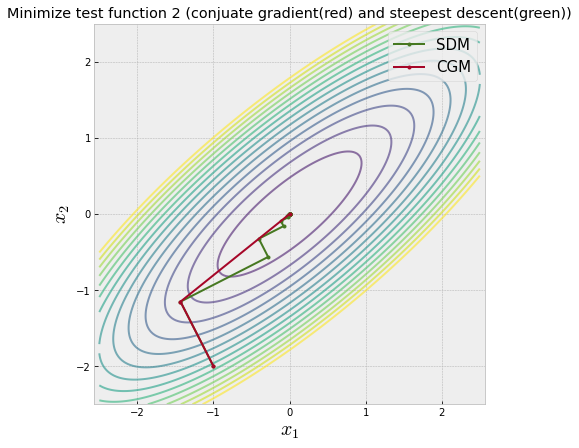

In [16]:
# 반복 히스토리를 저장할 전역변수와 콜백함수
Xk_sdm = []
def record_hist_sdm(xk) :
    global Xk_sdm
    Xk_sdm.append(xk)

Xk_cgm = []    
def record_hist_cgm(xk) :
    global Xk_cgm
    Xk_cgm.append(xk)
    
x0 = np.array([-1, -2])

x_star = minimize(f_2, x0, jac=df_2, args=(-0.7,), method="SDM", 
                  lineargs={'delta':1.0e-3}, callback=record_hist_sdm)
Xk_sdm = np.r_['0,2,1', x0, np.asarray(Xk_sdm)]

print('\n')

x_star = minimize(f_2, x0, jac=df_2, args=(-0.7,), method="CGFR", 
                  lineargs={'delta':1.0e-3}, callback=record_hist_cgm)
Xk_cgm = np.r_['0,2,1', x0, np.asarray(Xk_cgm)]

x = np.linspace(-2.5, 2.5, 200)
y = np.linspace(-2.5, 2.5, 200)

X,Y = np.meshgrid(x,y)

Z = f_2([X, Y], -0.7)

plt.figure(figsize=(7,7))
plt.contour(X, Y, Z, levels=np.linspace(0, 1, 15), alpha=0.6)
plt.plot(Xk_sdm[:,0], Xk_sdm[:,1], '.-', color=style_colors[3], label='SDM')
plt.plot(Xk_cgm[:,0], Xk_cgm[:,1], '.-', color=style_colors[1], label='CGM')
plt.title('Minimize test function 2 (conjuate gradient(red) and steepest descent(green))')
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)
plt.legend(fontsize=15)
plt.axis('equal')
plt.show()

### f_3을 고정 러닝레이트로 풀어보기

- minimize 함수의 인자 두개를 `linesrch=None`, `lineargs={'lr':0.0015}`로 세팅하고 함수를 호출

################################################################
# START OPTIMIZATION
################################################################
INIT POINT : [-2.  3.], dtype : float64
METHOD     : Conjugate gradient Polak and Ribiere
##############
# START ITER.
##############
Iter:    1, |c|:420.0761836, alpha:0.0015000, Cost: 86.3207732, d:[408. 100.], x:[-1.388  3.15 ]
Iter:  501, |c|:  2.6265466, alpha:0.0015000, Cost:  9.2997583, d:[ 1.1366 -2.3701], x:[-1.0449  1.1156]
Iter: 1001, |c|:  1.8245936, alpha:0.0015000, Cost:  1.9941610, d:[1.1676 1.3951], x:[0.5913 0.3357]
Iter: 1501, |c|:  0.8262563, alpha:0.0015000, Cost:  0.9161731, d:[0.3548 0.7453], x:[1.0443 1.0831]
Iter: 2001, |c|:  0.5618484, alpha:0.0015000, Cost:  0.5697257, d:[0.2084 0.5214], x:[1.2461 1.5475]
max-iter break
Iter: 2500, |c|:  0.4266009, alpha:0.0015000, Cost:  0.3904021, d:[0.1452 0.4009], x:[1.3758 1.8889]


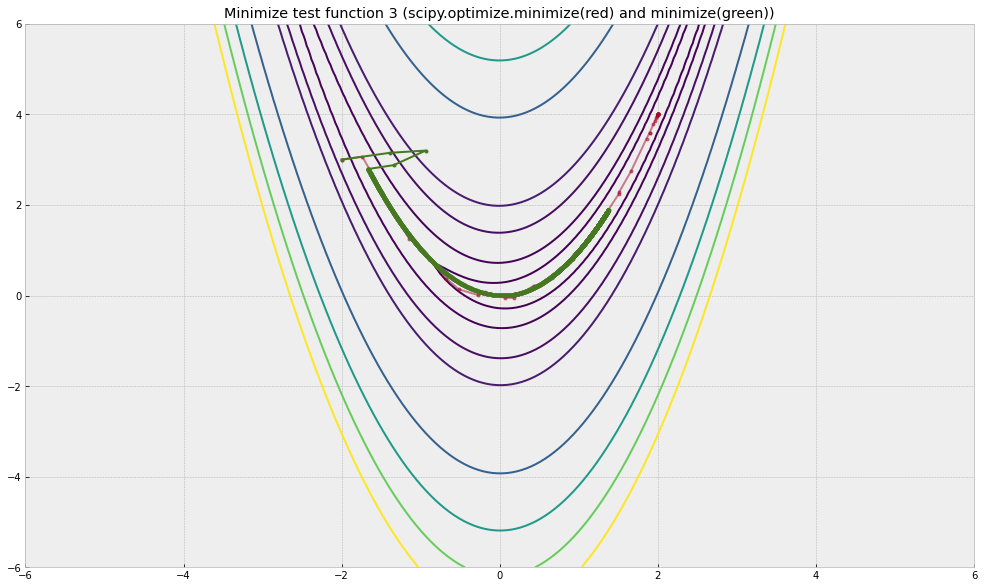

In [17]:
# 반복 히스토리를 저장할 전역변수와 콜백함수
my_Xk = []
def record_hist2(xk) :
    global my_Xk
    my_Xk.append(xk)

x0 =  np.array([-2.,3.])

#################################################################
# WRITE YOUR CODE HERE
x_star = minimize(f_3, x0, method="CGPR", linesrch=None, lineargs={'lr':0.0015}, 
                 strict=False, verbose_step=500, callback=record_hist2)
#################################################################


my_Xk = np.r_['0,2,1', x0, np.asarray(my_Xk)]

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)

X,Y = np.meshgrid(x,y)

Z = f_3([X, Y])

plt.figure(figsize=(17,10))
plt.contour(X, Y, Z, levels=np.concatenate((levels1, levels2, levels3)))
plt.plot(scipy_Xk[:,0], scipy_Xk[:,1], '.-', alpha=0.5, color=style_colors[1])
plt.plot(my_Xk[:,0], my_Xk[:,1], '.-', color=style_colors[3])
plt.title('Minimize test function 3 (scipy.optimize.minimize(red) and minimize(green))')
plt.show()

## 부록

### 1. 경사도 벡터는 함수표면의 접면에 수직

- 여기서 접면은 개념적 표현

- 2변수 실함수라면 접선이되고, 3변수 실함수라면 접면, 4변수 이상 실함수라면 초 접평면<sup>hyper tangent plane</sup>이 된다.

<img src="imgs/tang-grad2.png" width="550">


#### [증명]

 위 그림처럼 $f(\mathbf{x})= \text{constant}$인 곡면 위를 지나고 $\mathbf{x}^*$를 통과하는 임의의 곡선 $\mathbf{C}$에 대해서 곡선 $\mathbf{C}$가 $s$에 대해서 매개변수화되었다 하자. 다시말해 곡선 $\mathbf{C} = [\, f_1(s) \quad f_2(s) \quad f_3(s)\, ]^{\text{T}}$는 "일변수$s$에 대한 벡터함수"이다. 그림과 부합시키기 위해 곡선 $\mathbf{C}$를 요소 3개짜리 3차원 벡터함수로 적었지만 지금부터는 일반화 하여 $n$차원 곡선으로 생각하자.

이렇게 정의된 곡선 $\mathbf{C}$의 $\mathbf{x}^*$에서 접선벡터는 각 성분을 $s$에 대해 미분한 것이므로 다음과 같다.

$$
\mathbf{T} = \begin{bmatrix} \dfrac{\partial \, x_1}{\partial \, s} & \dfrac{\partial \, x_2}{\partial \, s} & \cdots & \dfrac{\partial \, x_n}{\partial \, s} \end{bmatrix}^{\text{T}}
$$

이제 매개변수 $s$가 미세하게 변할 때 곡면 함수 $f(\mathbf{x})$의 변화를 생각하자. 곡면 함수 $f(\mathbf{x})$를 $s$로 미분하는 것이다. 그런데 $s$가 변해감에 따라 곡면 함수 $f(\mathbf{x})$의 값은 변하지 않고 상수<sup>constants</sup>로 일정하므로

$$
\frac{\partial f}{\partial s} = 0
$$

가 되고, 위 미분을 위해 미분의 연쇄법칙을 적용하면

$$
\frac{\partial f}{\partial s} = \color{OrangeRed}{\frac{\partial f}{\partial x_1}}\color{RoyalBlue}{\frac{\partial x_1}{\partial s}} + \color{OrangeRed}{\frac{\partial f}{\partial x_2}}\color{RoyalBlue}{\frac{\partial x_2}{\partial s}} + \cdots + \color{OrangeRed}{\frac{\partial f}{\partial x_n}}\color{RoyalBlue}{\frac{\partial x_n}{\partial s}} =0
$$

로 풀어 적을 수 있다. 위 식을 파란색 부분과 주황색 부분을 따로 모아 행렬형식으로 쓰면


$$
\frac{\partial f}{\partial s} = \begin{bmatrix}\color{OrangeRed}{\dfrac{\partial f}{\partial x_1}} & \color{OrangeRed}{\dfrac{\partial f}{\partial x_2}} & \cdots &  \color{OrangeRed}{\dfrac{\partial f}{\partial x_n}} \end{bmatrix}^{\text{T}}  \begin{bmatrix} \color{RoyalBlue}{\dfrac{\partial x_1}{\partial s}} & \color{RoyalBlue}{\dfrac{\partial x_2}{\partial s}} & \cdots & \color{RoyalBlue}{\dfrac{\partial x_n}{\partial s}}\end{bmatrix} =  0
$$

결국 주황부분은 경사도벡터, 파란부분은 접선벡터 $\mathbf{T}$가 되고 

$$
\color{OrangeRed}{\mathbf{c}} \cdot \color{RoyalBlue}{ \mathbf{T} }= 0
$$

경사도벡터 $\mathbf{c}$는 접선과의 내적이 0이므로 접선에 수직이 된다.

### 2. 경사도벡터의 방향은 함수의 최대증가방향


<img src="imgs/tang-grad2.png" width="550">


#### [증명]

이번에는 $\mathbf{x}^*$에서 접선 방향이 아닌  방향으로의 단위벡터를 $\mathbf{u}$라 하자. $\mathbf{x}^*$에서 $\mathbf{u}$방향으로의 변화는 $\mathbf{x}^* + t \, \mathbf{u}$로 표시할 수 있다. 이제 점 $\mathbf{x}^*$에서 $\mathbf{u}$방향으로 $t$에 대한 미분을 생각해 볼 수 있는데 이러한 미분을 특정 방향으로 미분한다 하여 방향미분이라 한다. 이 방향미분을 미분의 정의대로 쓰면 다음과 같다.

$$
\nabla_{\mathbf{u}} f = \lim_{t \to 0} \frac{f(\mathbf{x}^* + t \, \mathbf{u}) - f(\mathbf{x^*})}{t} \tag{*}
$$

이제 분자의 $f(\mathbf{x}^* + t \, \mathbf{u})$을 테일러 시리즈 전개하면

$$
f( \mathbf{x}^* + t \mathbf{u}) = f(\mathbf{x}^*) + t \left[ u_1 \frac{\partial f}{\partial x_1} + u_2 \frac{\partial f}{\partial x_2} + \cdots + u_n \frac{\partial f}{\partial x_n} \right] + O\left(t^2\right)
$$

전개된 결과에 시그마 기호를 도입하고 양변에 $f(\mathbf{x}^*)$를 빼면 다음과 같다.

$$
f( \mathbf{x}^* + t \mathbf{u} ) - f(\mathbf{x}^*) = t \sum_{i=1}^n u_i \frac{\partial f}{\partial x_i}+ O\left(t^2\right)
$$

이 결과를 방향미분 정의식 $(*)$에 대입하면 분자, 분모의 $t$는 약분되고 $O\left(t^2\right) \to 0$가 되어 극한값은 다음처럼 된다.

$$
\begin{aligned}
\nabla_{\mathbf{u}} f &=  \lim_{t \to 0} \frac{ t \sum_{i=1}^n u_i \frac{\partial f}{\partial x_i}+ O\left(t^2\right)}{t} \\[5pt]
&= \sum_{i=1}^n u_i \frac{\partial f}{\partial x_i} =  \mathbf{c} \cdot \mathbf{u}
\end{aligned}
$$

즉, 함수 $f(\mathbf{x})$에 대한 $\mathbf{u}$방향으로 변화율은 경사도벡터 함수  $f(\mathbf{x})$의 $\mathbf{c}$와 변화를 주는 방향의 단위벡터 $\mathbf{u}$의 내적이라는 결과가 나온다. 내적의 정의는 다음과 같으므로

$$
 \mathbf{c} \cdot \mathbf{u} = \lvert  \mathbf{c} \rvert \lvert \mathbf{u} \rvert \cos \theta
$$

이 내적값 즉, $\mathbf{u}$ 방향으로 변화율이 최대가 되려면 $\theta$가 0&deg; 또는 180&deg; 가 되어야 한다. 따라서 경사도벡터 방향으로 변화할때 변화율이 가장 크다. 그리고 그 변화율은 경사도벡터의 크기이다. ($\because \lvert \mathbf{u} \rvert = 1, \quad \cos \theta = 1$)



### 3. 강하방향: 어떤 방향이 바람직한 $\mathbf{d}^{(k)}$ 방향인가?

반복의 목적은 목적함수 $f(\mathbf{x})$의 최소점에 도달하는 것이다. 알고리즘의 $k$번째 반복에서 $\mathbf{x}^{(k)}$가 최소점이 아니라면 더 작은 목적함수값을 가지는 다른점  $\mathbf{x}^{(k+1)}$이 있는 이야기가 된다. 다음식을 만족시키는 $\mathbf{x}^{(k+1)}$가 있다.

$$
f\left(\mathbf{x}^{(k+1)}\right) < f\left(\mathbf{x}^{(k)}\right)
$$

$\mathbf{x}^{(k+1)}$는 어떤 방향  $\mathbf{d}^{(k)}$로 $\alpha$만큼 이동한 위치이므로 위 식 좌변에 $\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}$을 대입한다.

$$
f\left(\mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}\right) <  f\left(\mathbf{x}^{(k)}\right) \tag{*}
$$

한편 테일러 시리즈의 표준모양은 다음과 같음을 이미 알아보았다.

$$
f(\mathbf{x}^* + \mathbf{d}) = f(\mathbf{x}^*) +  \nabla f^{\text{T}} \mathbf{d} + \frac{1}{2} \mathbf{d}^{\text{T}} \mathbf{H} \mathbf{d} + R
$$

$ f\left( \mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}\right)$는 $f\left( \mathbf{x}^{(k)} \right)$에서 $\alpha_k \mathbf{d}^{(k)}$만큼 변화한 것이므로 위 형태에 맞춰 테일러 시리즈 전개하면 ( $ \mathbf{c}^{(k)}$는 경사도벡터, 1계 미분항까지만 전개)

$$
 f\left(\mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}\right)= f\left(\mathbf{x}^{(k)} \right) + \color{Royalblue}{\mathbf{c}^{(k)} \cdot \left( \alpha_k \mathbf{d}^{(k)} \right)} +R
$$

전개한 결과를 $(*)$에 대입하고 테일러 시리즈에서 remainder항 $R$을 무시하면 다음과 같다.

$$
\begin{aligned}
f\left(\mathbf{x}^{(k)} + \alpha_k \mathbf{d}^{(k)}\right) 
&= f\left(\mathbf{x}^{(k)} \right) + \color{Royalblue}{\mathbf{c}^{(k)} \cdot \left( \alpha_k \mathbf{d}^{(k)} \right)} +R \\[5pt]
&\approx  f\left(\mathbf{x}^{(k)} \right) + \color{Royalblue}{\mathbf{c}^{(k)} \cdot \left( \alpha_k \mathbf{d}^{(k)} \right)} <  f\left(\mathbf{x}^{(k)}\right)
\end{aligned}
$$

따라서 최종적으로 다음과 같은 부등식을 얻는다.

$$
\begin{aligned}
\color{Royalblue}{\alpha_k \left( \mathbf{c}^{(k)} \cdot \mathbf{d}^{(k)} \right)}  &< 0 \\[5pt]
\color{Royalblue}{\mathbf{c}^{(k)} \cdot \mathbf{d}^{(k)}}  & < 0 \quad \because \alpha_k > 0
\end{aligned} 
$$

## 참고문헌

1. [arora] Intoruduction to Optimum Design 2nd ed., Jasbir S. Arora, Elsevier

2. [wiki:gss] Golden section search, https://en.wikipedia.org/wiki/Golden-section_search

3. [nocedal] Numerical Optimization 2en ed.- Chap 9 Derivative-Free Optimization, Jorge Nocedal, Stephen J. Wright, Springer

In [19]:
from IPython.core.display import HTML

def _set_css_style(css_file_path):
   """
   Read the custom CSS file and load it into Jupyter.
   Pass the file path to the CSS file.
   """
   styles = open(css_file_path, "r").read()
   s = '<style>%s</style>' % styles     
   return HTML(s)

_set_css_style("../../style.css")